# Initializing the trajectories in ADAPT simulation

## Problem statement

The data used in ADAPT simulation is composed of mean values and corresponding standard deviations at several moments during the course of experiment. Ideally, the model is in steady statesbefore ADAPT simulation starts. The initial parameters, initial states and fluxes can be constrained to be consistent. In other words, if the model is simulated using the initial parameters, the resulted states and fluxes should be steady (flat line).

In [1]:
# `pip install --user libroadrunner
# libncurse.so.5 required on linux
import roadrunner as rr
import pylab as p
import numpy as np
import pandas as pd

p.style.use('science')
# initialize the smallbone model
%matplotlib inline
smallbone_rr = rr.RoadRunner(
    "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000380.2?filename=BIOMD0000000380_url.xml")

## A brief recap of the Smallbone model

- 6 floating species
- 8 reactions

In [2]:
print(smallbone_rr.getFullStoichiometryMatrix())

       pgi, hxt, hxk, pgm, tpp, tps, nth, ugp
glc [[   0,   1,  -1,   0,   0,   0,   2,   0],
g1p  [   0,   0,   0,   1,   0,   0,   0,  -1],
g6p  [  -1,   0,   1,  -1,   0,  -1,   0,   0],
trh  [   0,   0,   0,   0,   1,   0,  -1,   0],
t6p  [   0,   0,   0,   0,  -1,   1,   0,   0],
udg  [   0,   0,   0,   0,   0,  -1,   0,   1]]



Simulation, the parameters and the states already forms a nice steady states.

In [3]:
ss = smallbone_rr.simulate(0, 10, 10000)

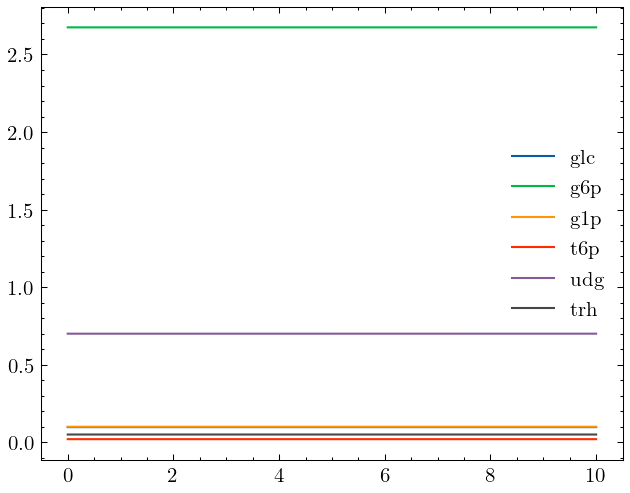

In [5]:
states = smallbone_rr.getIndependentFloatingSpeciesIds()
p.figure(figsize=(5, 4), dpi=150)
for s in states:
    p.plot(ss["time"], ss[f"[{s}]"])
p.legend(states)
p.savefig("vanilla.png")

The model can still reach to steady states after changing the initial concentration of the parameters.

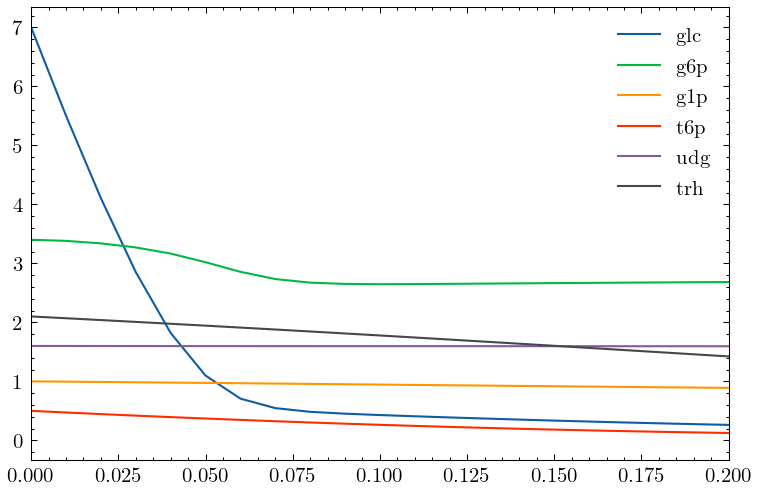

In [8]:
# reset the states of the model and change the initial parameter
smallbone_rr.reset()
smallbone_rr.glc_0 = 7
smallbone_rr.g1p_0 = 1
smallbone_rr.t6p_0 = 0.5
smallbone_rr.udg_0 = 1.6
smallbone_rr.trh_0 = 2.1
smallbone_rr.g6p_0 = 3.4
ss2 = smallbone_rr.simulate(0, 100, 10000)
p.figure(figsize=(6, 4), dpi=150)
p.style.use('science')
for s in states:
    p.plot(ss2["time"], ss2[f"[{s}]"])
p.xlim([0, 0.2])
# p.ylim([0.05, 0.15])
p.legend(states)
p.savefig("10000point.png")

Steady state solution is a long term response of the system, hence, has nothing to do with the initial conditions.

The two simulation with different initial conditions arrives at the same steady states. So far so good.

In [13]:
pd.DataFrame((ss2 - ss)[[0, -1], 1:],
             columns=states,
             index=["begin", "end"])

,glc,g6p,g1p,t6p,udg,trh
begin,6.902350e+00,9.000000e-01,7.250000e-01,2.050000e+00,4.800000e-01,0.900000
end,1.357726e-07,7.831990e-07,-4.819072e-08,2.525873e-07,9.736703e-08,0.000006


## ADAPT

Simulate steady state of Smallbone model in `pyADAPT

In [16]:
smallbone.state_order

['glc', 'g1p', 'g6p', 'trh', 't6p', 'udg']

In [22]:
from pyADAPT.examples import Smallbone2011
smallbone = Smallbone2011()
time = np.linspace(0, 100,10000)
ss3 = smallbone.compute_states(time_points=time,
#                              x0=smallbone.initial_states,
                               x0=np.array([7, 1, 3.4, 2.1,0.5, 1.6]),
                             odesolver="Radau")

Text(0.5, 1.0, 'Steady state with \\texttt{pyADAPT}')

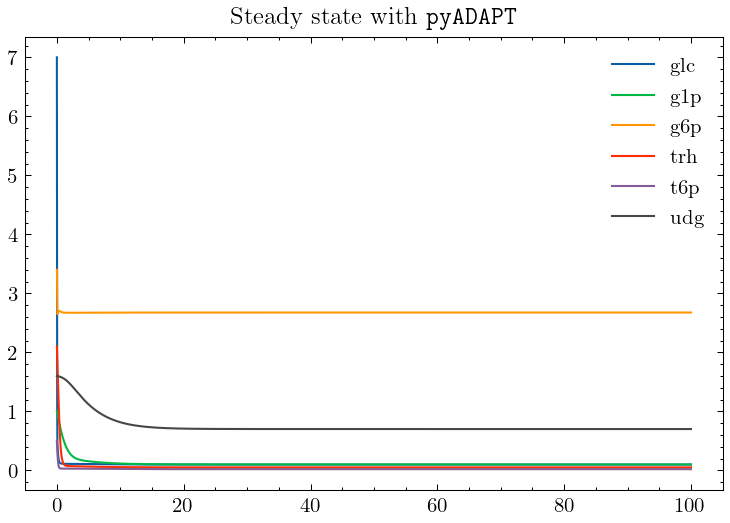

In [23]:
p.figure(figsize=(6,4), dpi=150)
p.plot(time, ss3.T)
p.legend(smallbone.state_order)
p.title(r"Steady state with \texttt{pyADAPT}")

However, at the beginning of ADAPT simulation, the model has to be **randomized**. The parameters and the states are randomized separately, and no longer guarantee the initial constraint mentioned earlier, that if your . This leads to the problem I am facing right now.

In [2]:
from trehalose.van_heerden_preprocess import vhd
vhd_dataset = vhd(padding=False, smooth=False)

In [3]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
p.figure(figsize=(6, 4), dpi=150)
time = vhd_dataset.get_timepoints(n_ts=300)
d = vhd_dataset.interpolate(n_ts=300)

for i,s in enumerate(d):
    name = vhd_dataset.names[i]
    p.plot(range(-10, 0), ss2[f"[{name}]"], '.', color=colors[i], label=name)
    p.plot(time, s[:, 0], '--', color=colors[i],  label=name)
# p.legend(vhd_dataset.names)
p.xlim([-5, 5])
p.ylim([0, 10])
p.title("Zoomed view at the start of ADAPT simulation")
p.legend(ncol=2)

NameError: name 'ss2' is not defined

<Figure size 900x600 with 0 Axes>

## Design flaws (possible) in the old ADAPT implementation

Integration and differentiation should be mutually inverse process. By solving an ODE system, ADAPT is actually trying to **integrate** the derivatives to find the original function numerically. Then, the least square optimizer will optimize the parameters so that the error between the original functions and the splines are minimized. In other word, the original function should look like the splines.

Let's see what happens at `t = 0` in the figure above. (why the parameter trajectories always have a sharp bounced peak at the beginning)

First of all, let's assume that we are only dealing with systems with a steady state
Random parameters are used to simulate the model with random states. 

the old implementations all fail at addressing one point:
It tries to solve an ODE system (integration) whose original functions are not **differentiable**.

## The question I asked during the CBio meeting today (May 27)

## TODO

- use Smallbone's parameters as the initial values as they are the only parameters that produces a steady states so far
- pad the dataset with same values at t = -1
- maybe the parameters don't need to be randomized at all?
- just time! no discriptor... fancy words
- plot phase diagram

In [35]:
y.shape

(6, 100)

The dataset in pyADAPT has a padding option, which can ensure that the derivative at the beginning is always 0. This means that before intervention, the system was in steady states.

In [34]:
better_vhd = vhd(padding=False, smooth=True)

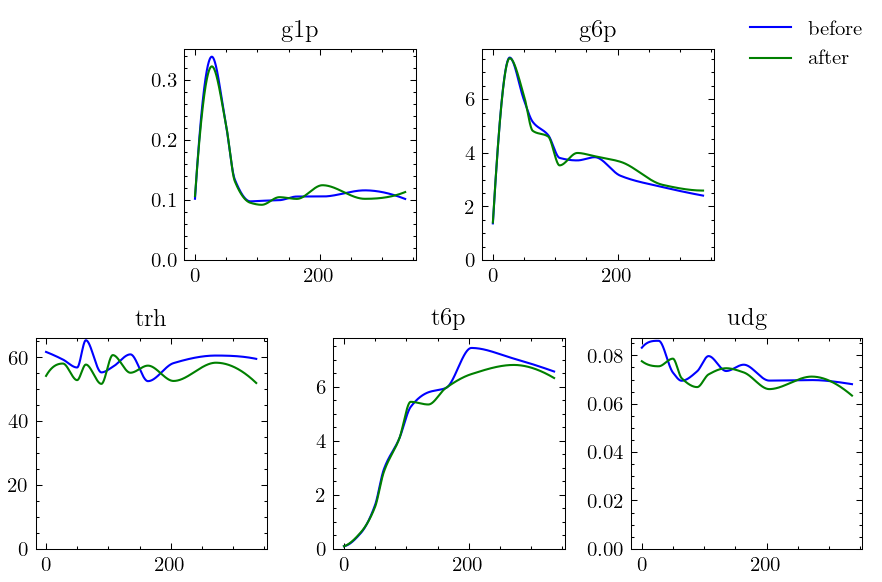

In [41]:
nts=5000
t = vhd_dataset.get_timepoints(nts)
interp = vhd_dataset.interpolate(nts)
better_interp = better_vhd.interpolate(nts)

fig = p.figure(figsize=(6, 4), dpi=150)
gs = fig.add_gridspec(4, 6)
fig.add_subplot(gs[0:2, 1:3])
fig.add_subplot(gs[0:2, 3:5])
fig.add_subplot(gs[2:4, 0:2])
fig.add_subplot(gs[2:4, 2:4])
fig.add_subplot(gs[2:4, 4:6])

legend = False
handles = []
for i, a in enumerate(fig.axes):
    bf, = a.plot(t, interp[i, :, 0], "b", label="before")
    af, = a.plot(t, better_interp[i, :, 0], "g", label="after")
    # if not legend:
    if not handles:
        handles = [bf, af]
#     a.set_xlim([-0.5, 25])
    a.set_ylim(bottom=0)
    a.set_title(vhd_dataset.names[i])
fig.legend(handles, ["before", "after"])
fig.tight_layout()

The initial parameters are optimized such that the model is at steady states and the species concentation are at the beginning of the spline. In other word, the model is continuous before and after the intervention begins.

## smoothing the data

In [19]:
from scipy.ndimage import gaussian_filter1d

In [20]:
trh = vhd_dataset['trh'].means
time = vhd_dataset['trh'].time

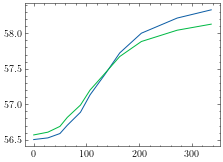

In [21]:
plt.plot(time, trh)
plt.plot(time, gaussian_filter1d(trh, 2))

In [22]:
udg = vhd_dataset['udg'].means

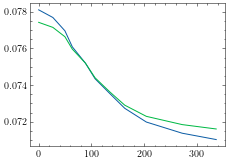

In [23]:
plt.plot(time, udg)
plt.plot(time, gaussian_filter1d(udg, 2))

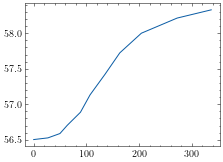

In [24]:
p.plot(vhd_dataset['trh'].time, vhd_dataset['trh'].means)

In [25]:
import numpy as np

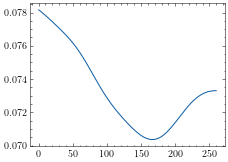

In [26]:
window = np.hamming(100)
kernel = window / window.sum()
hmv = np.convolve(kernel, interp[4, :, 0], mode="valid")
p.plot(hmv)

In [27]:
vhd_dataset.names

['g1p', 'g6p', 'trh', 't6p', 'udg']